# Semi-Supervised Architope (Financial Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [21]:
# Test-size Ratio
test_size_ratio = 1
min_height = 50

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 5000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [22]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  5001


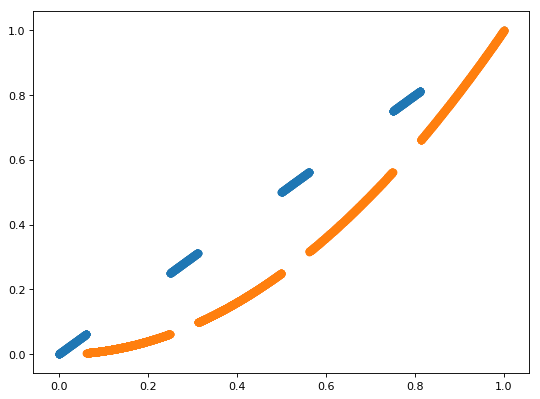

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [7]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [8]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print((N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
#                 y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Apply Random Partitioner to the given Dataset

In [9]:
import time
partitioning_time_begin = time.time()

In [10]:
if Option_Function == 'SnP':
    q_in_auto = .8
    Min_data_size_percentage_auto = .1
    min_size_part = 100
else:
    if Option_Function == 'crypto':
        q_in_auto = .99
        Min_data_size_percentage_auto = .3
        min_size_part = 100
    if Option_Function == 'Motivational_Example':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 10
        # Partition Based on Y
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
    else:
        q_in_auto = .5
        Min_data_size_percentage_auto = .3
        min_size_part = 100

In [11]:
# Initialize Number of Parts currently generated
N_parts_generated = 0

# Generate Partition (with option to regernerate if only 1 part is randomly produced)
while N_parts_generated < 2:
    # Generate Parts
    X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                      q_in=q_in_auto, 
                                                                      X_train_in=X_train, 
                                                                      y_train_in=data_y, 
                                                                      CV_folds_failsafe=CV_folds,
                                                                      min_size = min_size_part)
    
    # Update Number of Parts
    N_parts_generated = len(X_parts_list)
    # Shuffle hyperparameters
    Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
    q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1
    
    # Update User
    print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')
    
# Trash removal (removes empty parts)
X_parts_list = list(filter(([]).__ne__, X_parts_list))
y_parts_list = list(filter(([]).__ne__, y_parts_list))
    
    
# ICML Rebuttle Deadline = Coersion!
if Option_Function == 'Motivational_Example':
    # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
    holder_temp = data_y
    data_y = X_train
    X_train = holder_temp
    holder_temp = y_parts_list
    y_parts_list = X_parts_list
    X_parts_list = holder_temp

0.6660667866426715
0.42451509698060386
0.2501499700059988
0.047590481903619274
0.0
The_parts_listhe number of parts are: 6.


In [12]:
partitioning_time = time.time() - partitioning_time_begin

In [13]:
print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

The_parts_listhe number of parts are: 5.


#### Building Training Predictions on each part
- Train locally (on each "naive part")
- Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
- Generate predictions on all of testing-set (will be selected between later using classifier)

In [14]:
# Time-Elapse (Start) for Training on Each Part
Architope_partition_training_begin = time.time()
# Initialize running max for Parallel time
Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
# Initialize N_parameter counter for Architope
N_params_Architope = 0

In [15]:
# Silly Coercsion for ICML rebuttle deadline timeline
if Option_Function == 'Motivational_Example':
    Iteration_Length = len(X_parts_list) -1
else:
    Iteration_Length = len(X_parts_list)

    
# Train each part!
for current_part in range(Iteration_Length):
    #==============#
    # Timer(begin) #
    #==============#
    current_part_training_time_for_parallel_begin = time.time()
    
    
    # Initializations #
    #-----------------#
    # Reload Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Modify heights according to optimal (data-driven) rule (with threshold)
    current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
    current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
    current_height = np.maximum(current_height,current_height_threshold)
    current_height = current_height.astype(int).tolist()
    param_grid_Vanilla_Nets['height'] = current_height
    # Automatically Fix Input Dimension
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
    param_grid_Vanilla_Nets['output_dim'] = [1]
    
    # Update User #
    #-------------#
    print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
    print('Heights to iterate over: '+str(current_height))
    
    # Generate Prediction(s) on current Part #
    #----------------------------------------#
    # Failsafe (number of data-points)
    CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
    # Train Network
    y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                     n_jobs = n_jobs,
                                                                                     n_iter = n_iter, 
                                                                                     param_grid_in = param_grid_Vanilla_Nets, 
                                                                                     X_train= X_parts_list[current_part], 
                                                                                     y_train=y_parts_list[current_part],
                                                                                     X_test_partial=X_train,
                                                                                     X_test=X_test)
    
    # Append predictions to data-frames
    ## If first prediction we initialize data-frames
    if current_part==0:
        # Register quality
        training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
        training_quality = training_quality.reshape(training_quality.shape[0],1)

        # Save Predictions
        predictions_train = y_hat_train_full_loop
        predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
        predictions_test = y_hat_test_full_loop
        predictions_test = predictions_test.reshape(predictions_test.shape[0],1)
        
        
    ## If not first prediction we append to already initialized dataframes
    else:
    # Register Best Scores
        #----------------------#
        # Write Predictions 
        # Save Predictions
        y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],1)
        predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
        y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],1)
        predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)
        
        # Evaluate Errors #
        #-----------------#
        # Training
        prediction_errors = np.abs(y_hat_train_loop.reshape(-1,)-y_train)
        training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)
        
    #============#
    # Timer(end) #
    #============#
    current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
    Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)

    #============---===============#
    # N_parameter Counter (Update) #
    #------------===---------------#
    N_params_Architope = N_params_Architope + N_params_Architope_loop

# Update User
#-------------#
print(' ')
print(' ')
print(' ')
print('----------------------------------------------------')
print('Feature Generation (Learning Phase): Score Generated')
print('----------------------------------------------------')
print(' ')
print(' ')
print(' ')

Status: Current part: 0 out of : 5 parts.
Heights to iterate over: [334]
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  3.2min finished


Epoch 1/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0369 - mse: 0.0024 - mae: 0.0369 - mape: 190.2451
Epoch 2/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0286 - mse: 0.0016 - mae: 0.0286 - mape: 123.0746
Epoch 3/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0191 - mse: 6.5404e-04 - mae: 0.0191 - mape: 91.6425
Epoch 4/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0170 - mse: 5.4544e-04 - mae: 0.0170 - mape: 96.0993
Epoch 5/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0169 - mse: 5.7630e-04 - mae: 0.0169 - mape: 109.9137
Epoch 6/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0168 - mse: 5.6530e-04 - mae: 0.0168 - mape: 107.1641
Epoch 7/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0166 - mse: 5.6760e-04 - mae: 0.0166 - mape: 107.4657
Epoch 8/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0166 - mse: 5.5663e-04 -

53/53 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 1.6319e-04 - mae: 0.0059 - mape: 35.9207
Epoch 65/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 1.6579e-04 - mae: 0.0059 - mape: 31.0559
Epoch 66/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 1.6490e-04 - mae: 0.0059 - mape: 31.7242
Epoch 67/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 1.6698e-04 - mae: 0.0058 - mape: 33.9529
Epoch 68/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0057 - mse: 1.6346e-04 - mae: 0.0057 - mape: 32.9855
Epoch 69/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0059 - mse: 1.6926e-04 - mae: 0.0059 - mape: 34.4932
Epoch 70/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 1.6148e-04 - mae: 0.0058 - mape: 37.4202
Epoch 71/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0061 - mse: 1.6597e-04 - ma

53/53 [==============================] - 0s 5ms/step - loss: 0.0059 - mse: 1.6170e-04 - mae: 0.0059 - mape: 35.4507
Epoch 127/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0059 - mse: 1.5883e-04 - mae: 0.0059 - mape: 37.6576
Epoch 128/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 1.6047e-04 - mae: 0.0057 - mape: 37.8396
Epoch 129/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0062 - mse: 1.6231e-04 - mae: 0.0062 - mape: 34.0046
Epoch 130/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 1.5718e-04 - mae: 0.0057 - mape: 40.0806
Epoch 131/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 1.6101e-04 - mae: 0.0057 - mape: 35.0342
Epoch 132/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 1.6306e-04 - mae: 0.0056 - mape: 34.5314
Epoch 133/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0060 - mse: 1.6059e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 1.5280e-04 - mae: 0.0058 - mape: 43.2427
Epoch 189/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.5706e-04 - mae: 0.0055 - mape: 37.3280
Epoch 190/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 1.6063e-04 - mae: 0.0056 - mape: 35.6156
Epoch 191/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.0056 - mse: 1.6081e-04 - mae: 0.0056 - mape: 36.4784
Epoch 192/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0059 - mse: 1.5390e-04 - mae: 0.0059 - mape: 41.2851
Epoch 193/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0055 - mse: 1.5483e-04 - mae: 0.0055 - mape: 37.6723
Epoch 194/1000
53/53 [==============================] - 0s 9ms/step - loss: 0.0057 - mse: 1.5754e-04 - mae: 0.0057 - mape: 38.7974
Epoch 195/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0056 - mse: 1.4967e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 1.5041e-04 - mae: 0.0056 - mape: 41.7592
Epoch 251/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.5595e-04 - mae: 0.0055 - mape: 38.4885
Epoch 252/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.4596e-04 - mae: 0.0055 - mape: 43.4788
Epoch 253/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0057 - mse: 1.4923e-04 - mae: 0.0057 - mape: 45.3295
Epoch 254/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 1.4689e-04 - mae: 0.0054 - mape: 41.6635
Epoch 255/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 1.5152e-04 - mae: 0.0054 - mape: 40.6655
Epoch 256/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0054 - mse: 1.4680e-04 - mae: 0.0054 - mape: 42.8216
Epoch 257/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.0053 - mse: 1.4475e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 1.5098e-04 - mae: 0.0053 - mape: 43.3006
Epoch 313/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4538e-04 - mae: 0.0052 - mape: 44.7680
Epoch 314/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.4273e-04 - mae: 0.0055 - mape: 50.6052
Epoch 315/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 1.4951e-04 - mae: 0.0054 - mape: 43.7117
Epoch 316/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 1.4688e-04 - mae: 0.0053 - mape: 44.9759
Epoch 317/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0054 - mse: 1.4448e-04 - mae: 0.0054 - mape: 46.4858
Epoch 318/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 1.4309e-04 - mae: 0.0053 - mape: 48.0413
Epoch 319/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4573e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 1.4765e-04 - mae: 0.0054 - mape: 44.5196
Epoch 375/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 1.4577e-04 - mae: 0.0054 - mape: 45.0320
Epoch 376/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.5024e-04 - mae: 0.0055 - mape: 42.7301
Epoch 377/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 1.4319e-04 - mae: 0.0053 - mape: 48.1417
Epoch 378/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.4255e-04 - mae: 0.0055 - mape: 48.2336
Epoch 379/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 1.4558e-04 - mae: 0.0053 - mape: 46.6976
Epoch 380/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.4441e-04 - mae: 0.0055 - mape: 49.0789
Epoch 381/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4661e-

53/53 [==============================] - 0s 8ms/step - loss: 0.0053 - mse: 1.4383e-04 - mae: 0.0053 - mape: 47.1706
Epoch 437/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.0054 - mse: 1.4193e-04 - mae: 0.0054 - mape: 47.1496
Epoch 438/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.4198e-04 - mae: 0.0053 - mape: 47.9674
Epoch 439/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0053 - mse: 1.4908e-04 - mae: 0.0053 - mape: 41.4553
Epoch 440/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 1.4164e-04 - mae: 0.0052 - mape: 47.6813
Epoch 441/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0054 - mse: 1.4343e-04 - mae: 0.0054 - mape: 49.3342
Epoch 442/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0055 - mse: 1.4643e-04 - mae: 0.0055 - mape: 45.6178
Epoch 443/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.0056 - mse: 1.4772e-

53/53 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 1.4649e-04 - mae: 0.0052 - mape: 46.0090
Epoch 499/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.4656e-04 - mae: 0.0053 - mape: 46.3375
Epoch 500/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0054 - mse: 1.4929e-04 - mae: 0.0054 - mape: 44.5979
Epoch 501/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.4746e-04 - mae: 0.0053 - mape: 45.9445
Epoch 502/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.4567e-04 - mae: 0.0053 - mape: 46.4821
Epoch 503/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 1.4719e-04 - mae: 0.0053 - mape: 45.2158
Epoch 504/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4418e-04 - mae: 0.0052 - mape: 46.9437
Epoch 505/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 1.4519e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 1.4697e-04 - mae: 0.0053 - mape: 44.7413
Epoch 561/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4837e-04 - mae: 0.0052 - mape: 44.6361
Epoch 562/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.4503e-04 - mae: 0.0055 - mape: 45.1152
Epoch 563/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0055 - mse: 1.4523e-04 - mae: 0.0055 - mape: 46.4526
Epoch 564/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 1.4473e-04 - mae: 0.0052 - mape: 45.7520
Epoch 565/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.4804e-04 - mae: 0.0053 - mape: 44.7120
Epoch 566/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.4392e-04 - mae: 0.0052 - mape: 46.4282
Epoch 567/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.4461e-

53/53 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 1.4445e-04 - mae: 0.0053 - mape: 46.9683
Epoch 623/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.4207e-04 - mae: 0.0052 - mape: 46.5430
Epoch 624/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.0052 - mse: 1.4510e-04 - mae: 0.0052 - mape: 46.3438
Epoch 625/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.4801e-04 - mae: 0.0052 - mape: 44.3588
Epoch 626/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.4164e-04 - mae: 0.0052 - mape: 47.2665
Epoch 627/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4683e-04 - mae: 0.0052 - mape: 45.0050
Epoch 628/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4828e-04 - mae: 0.0052 - mape: 44.4777
Epoch 629/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 1.4514e-

53/53 [==============================] - 0s 7ms/step - loss: 0.0053 - mse: 1.4764e-04 - mae: 0.0053 - mape: 45.2264
Epoch 685/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.4201e-04 - mae: 0.0052 - mape: 48.1050
Epoch 686/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.4561e-04 - mae: 0.0053 - mape: 45.2081
Epoch 687/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 1.4338e-04 - mae: 0.0055 - mape: 49.0979
Epoch 688/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4337e-04 - mae: 0.0052 - mape: 46.6581
Epoch 689/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4288e-04 - mae: 0.0052 - mape: 47.2549
Epoch 690/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 1.4710e-04 - mae: 0.0052 - mape: 43.0242
Epoch 691/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 1.4490e-

53/53 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 1.4501e-04 - mae: 0.0053 - mape: 46.4296
Epoch 747/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 1.4719e-04 - mae: 0.0054 - mape: 46.4909
Epoch 748/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4677e-04 - mae: 0.0052 - mape: 45.7083
Epoch 749/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4143e-04 - mae: 0.0052 - mape: 49.3080
Epoch 750/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4646e-04 - mae: 0.0052 - mape: 46.8033
Epoch 751/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4114e-04 - mae: 0.0052 - mape: 49.3934
Epoch 752/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4399e-04 - mae: 0.0052 - mape: 46.9745
Epoch 753/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4507e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 1.4715e-04 - mae: 0.0053 - mape: 47.2222
Epoch 809/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4459e-04 - mae: 0.0052 - mape: 46.8964
Epoch 810/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4584e-04 - mae: 0.0052 - mape: 46.0763
Epoch 811/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4447e-04 - mae: 0.0052 - mape: 46.9993
Epoch 812/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4304e-04 - mae: 0.0052 - mape: 47.9734
Epoch 813/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 1.4419e-04 - mae: 0.0053 - mape: 47.0079
Epoch 814/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0054 - mse: 1.4463e-04 - mae: 0.0054 - mape: 49.2267
Epoch 815/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4590e-

53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4447e-04 - mae: 0.0052 - mape: 47.5361
Epoch 871/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4089e-04 - mae: 0.0052 - mape: 50.4157
Epoch 872/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0052 - mse: 1.4841e-04 - mae: 0.0052 - mape: 45.3946
Epoch 873/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.4442e-04 - mae: 0.0052 - mape: 47.9796
Epoch 874/1000
53/53 [==============================] - 0s 7ms/step - loss: 0.0053 - mse: 1.4572e-04 - mae: 0.0053 - mape: 46.5302
Epoch 875/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 1.4089e-04 - mae: 0.0053 - mape: 51.0870
Epoch 876/1000
53/53 [==============================] - 0s 9ms/step - loss: 0.0053 - mse: 1.4440e-04 - mae: 0.0053 - mape: 47.5042
Epoch 877/1000
53/53 [==============================] - 0s 8ms/step - loss: 0.0052 - mse: 1.4316e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4180e-04 - mae: 0.0052 - mape: 50.6515
Epoch 933/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 1.4694e-04 - mae: 0.0051 - mape: 47.1162
Epoch 934/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.0051 - mse: 1.4705e-04 - mae: 0.0051 - mape: 46.8473
Epoch 935/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4584e-04 - mae: 0.0052 - mape: 48.0095
Epoch 936/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0052 - mse: 1.4229e-04 - mae: 0.0052 - mape: 50.1421
Epoch 937/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 1.4666e-04 - mae: 0.0051 - mape: 47.8872
Epoch 938/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 1.4929e-04 - mae: 0.0051 - mape: 44.4509
Epoch 939/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 1.4360e-

53/53 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 1.4855e-04 - mae: 0.0051 - mape: 48.8225
Epoch 995/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 1.4797e-04 - mae: 0.0052 - mape: 50.3255
Epoch 996/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 1.4589e-04 - mae: 0.0051 - mape: 51.0004
Epoch 997/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 1.5047e-04 - mae: 0.0051 - mape: 49.2908
Epoch 998/1000
53/53 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 1.4713e-04 - mae: 0.0050 - mape: 50.2760
Epoch 999/1000
53/53 [==============================] - 0s 6ms/step - loss: 0.0050 - mse: 1.4835e-04 - mae: 0.0050 - mape: 51.4090
Epoch 1000/1000
157/157 [==============================] - 0s 2ms/step
Status: Current part: 1 out of : 5 parts.
Heights to iterate over: [213]
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:  1.6min finished


Epoch 1/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.2158 - mse: 0.0543 - mae: 0.2158 - mape: 77.6222
Epoch 2/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0693 - mse: 0.0072 - mae: 0.0693 - mape: 26.6578
Epoch 3/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0613 - mse: 0.0050 - mae: 0.0613 - mape: 25.0363
Epoch 4/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0607 - mse: 0.0048 - mae: 0.0607 - mape: 24.9667
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0603 - mse: 0.0047 - mae: 0.0603 - mape: 24.8713
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0601 - mse: 0.0048 - mae: 0.0601 - mape: 25.6368
Epoch 7/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0592 - mse: 0.0048 - mae: 0.0592 - mape: 25.8499
Epoch 8/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0584 - mse: 0.0048 - mae: 0.0584 - mape: 25.5837


38/38 [==============================] - 0s 3ms/step - loss: 0.0566 - mse: 0.0047 - mae: 0.0566 - mape: 25.7551
Epoch 67/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0558 - mse: 0.0048 - mae: 0.0558 - mape: 25.8622
Epoch 68/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0560 - mse: 0.0048 - mae: 0.0560 - mape: 25.9230
Epoch 69/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0561 - mse: 0.0049 - mae: 0.0561 - mape: 25.9947
Epoch 70/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0558 - mse: 0.0048 - mae: 0.0558 - mape: 25.8764
Epoch 71/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0560 - mse: 0.0047 - mae: 0.0560 - mape: 25.7497
Epoch 72/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0559 - mse: 0.0048 - mae: 0.0559 - mape: 25.8439
Epoch 73/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0558 - mse: 0.0048 - mae: 0.0558 - mape: 25.8090
Epoch 

38/38 [==============================] - 0s 3ms/step - loss: 0.0531 - mse: 0.0042 - mae: 0.0531 - mape: 24.3964
Epoch 131/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0525 - mse: 0.0043 - mae: 0.0525 - mape: 24.4660
Epoch 132/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0522 - mse: 0.0040 - mae: 0.0522 - mape: 23.6934
Epoch 133/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0501 - mse: 0.0038 - mae: 0.0501 - mape: 23.0873
Epoch 134/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0475 - mse: 0.0033 - mae: 0.0475 - mape: 21.7492
Epoch 135/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0433 - mse: 0.0028 - mae: 0.0433 - mape: 19.8430
Epoch 136/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.0342 - mse: 0.0017 - mae: 0.0342 - mape: 15.4657
Epoch 137/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0233 - mse: 9.7699e-04 - mae: 0.0233 - mape: 9.7

38/38 [==============================] - 0s 3ms/step - loss: 0.0185 - mse: 6.2654e-04 - mae: 0.0185 - mape: 7.5155
Epoch 194/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0179 - mse: 6.0953e-04 - mae: 0.0179 - mape: 7.2334
Epoch 195/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0186 - mse: 6.2581e-04 - mae: 0.0186 - mape: 7.6329
Epoch 196/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0184 - mse: 6.3362e-04 - mae: 0.0184 - mape: 7.3634
Epoch 197/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0183 - mse: 6.2530e-04 - mae: 0.0183 - mape: 7.3306
Epoch 198/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0182 - mse: 6.2777e-04 - mae: 0.0182 - mape: 7.4298
Epoch 199/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0181 - mse: 6.1926e-04 - mae: 0.0181 - mape: 7.3681
Epoch 200/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0180 - mse: 6.2145e-04 - ma

38/38 [==============================] - 0s 3ms/step - loss: 0.0176 - mse: 6.1566e-04 - mae: 0.0176 - mape: 7.1155
Epoch 257/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0176 - mse: 6.1278e-04 - mae: 0.0176 - mape: 7.1678
Epoch 258/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0178 - mse: 6.3003e-04 - mae: 0.0178 - mape: 7.2246
Epoch 259/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0179 - mse: 6.3707e-04 - mae: 0.0179 - mape: 7.2166
Epoch 260/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0179 - mse: 6.4177e-04 - mae: 0.0179 - mape: 7.2432
Epoch 261/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0178 - mse: 6.1750e-04 - mae: 0.0178 - mape: 7.2425
Epoch 262/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0180 - mse: 6.6395e-04 - mae: 0.0180 - mape: 7.2668
Epoch 263/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0175 - mse: 6.0451e-04 - ma

38/38 [==============================] - 0s 3ms/step - loss: 0.0173 - mse: 6.1522e-04 - mae: 0.0173 - mape: 7.0041
Epoch 320/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0170 - mse: 6.2659e-04 - mae: 0.0170 - mape: 6.8102
Epoch 321/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0173 - mse: 6.2495e-04 - mae: 0.0173 - mape: 6.9494
Epoch 322/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0173 - mse: 6.1890e-04 - mae: 0.0173 - mape: 7.0259
Epoch 323/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0171 - mse: 6.3434e-04 - mae: 0.0171 - mape: 6.8255
Epoch 324/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0171 - mse: 6.2578e-04 - mae: 0.0171 - mape: 6.8569
Epoch 325/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0171 - mse: 6.2713e-04 - mae: 0.0171 - mape: 6.8487
Epoch 326/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0176 - mse: 6.3482e-04 - ma

38/38 [==============================] - 0s 4ms/step - loss: 0.0160 - mse: 6.5690e-04 - mae: 0.0160 - mape: 6.3362
Epoch 383/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0160 - mse: 6.3553e-04 - mae: 0.0160 - mape: 6.3346
Epoch 384/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 6.5134e-04 - mae: 0.0158 - mape: 6.2389
Epoch 385/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 6.4409e-04 - mae: 0.0158 - mape: 6.2509
Epoch 386/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 6.5558e-04 - mae: 0.0157 - mape: 6.2087
Epoch 387/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0160 - mse: 6.5868e-04 - mae: 0.0160 - mape: 6.3116
Epoch 388/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 6.5100e-04 - mae: 0.0157 - mape: 6.1573
Epoch 389/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0156 - mse: 6.4987e-04 - ma

38/38 [==============================] - 0s 3ms/step - loss: 0.0127 - mse: 5.5092e-04 - mae: 0.0127 - mape: 4.8953
Epoch 446/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0129 - mse: 5.5425e-04 - mae: 0.0129 - mape: 4.8985
Epoch 447/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0131 - mse: 5.6170e-04 - mae: 0.0131 - mape: 4.9634
Epoch 448/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0126 - mse: 5.5520e-04 - mae: 0.0126 - mape: 4.7984
Epoch 449/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0128 - mse: 5.3908e-04 - mae: 0.0128 - mape: 4.9072
Epoch 450/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0126 - mse: 5.4176e-04 - mae: 0.0126 - mape: 4.7859
Epoch 451/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0129 - mse: 5.3588e-04 - mae: 0.0129 - mape: 4.9295
Epoch 452/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0125 - mse: 5.3205e-04 - ma

38/38 [==============================] - 0s 2ms/step - loss: 0.0112 - mse: 3.9348e-04 - mae: 0.0112 - mape: 4.2301
Epoch 509/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0112 - mse: 3.9534e-04 - mae: 0.0112 - mape: 4.1979
Epoch 510/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0111 - mse: 3.9704e-04 - mae: 0.0111 - mape: 4.2166
Epoch 511/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0113 - mse: 3.9479e-04 - mae: 0.0113 - mape: 4.2822
Epoch 512/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0110 - mse: 3.9092e-04 - mae: 0.0110 - mape: 4.1404
Epoch 513/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0110 - mse: 3.8475e-04 - mae: 0.0110 - mape: 4.1657
Epoch 514/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0112 - mse: 3.8260e-04 - mae: 0.0112 - mape: 4.2615
Epoch 515/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0110 - mse: 3.7560e-04 - ma

38/38 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 2.5507e-04 - mae: 0.0091 - mape: 3.4818
Epoch 572/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0087 - mse: 2.5368e-04 - mae: 0.0087 - mape: 3.3305
Epoch 573/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0087 - mse: 2.4094e-04 - mae: 0.0087 - mape: 3.3492
Epoch 574/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0089 - mse: 2.4536e-04 - mae: 0.0089 - mape: 3.3899
Epoch 575/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0084 - mse: 2.3578e-04 - mae: 0.0084 - mape: 3.2414
Epoch 576/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0085 - mse: 2.3458e-04 - mae: 0.0085 - mape: 3.2653
Epoch 577/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0094 - mse: 2.3294e-04 - mae: 0.0094 - mape: 3.5674
Epoch 578/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0085 - mse: 2.2542e-04 - ma

38/38 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 2.5352e-05 - mae: 0.0036 - mape: 1.3500
Epoch 635/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 1.7787e-05 - mae: 0.0028 - mape: 1.0837
Epoch 636/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 1.7999e-05 - mae: 0.0030 - mape: 1.1325
Epoch 637/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 2.0458e-05 - mae: 0.0032 - mape: 1.2198
Epoch 638/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 1.8764e-05 - mae: 0.0030 - mape: 1.1396
Epoch 639/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 1.7094e-05 - mae: 0.0027 - mape: 1.0525
Epoch 640/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 1.5896e-05 - mae: 0.0027 - mape: 1.0306
Epoch 641/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 1.7808e-05 - ma

38/38 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 1.6284e-05 - mae: 0.0027 - mape: 0.9829
Epoch 698/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0034 - mse: 2.1792e-05 - mae: 0.0034 - mape: 1.2325
Epoch 699/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 1.9156e-05 - mae: 0.0029 - mape: 1.0880
Epoch 700/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 1.5735e-05 - mae: 0.0022 - mape: 0.8485
Epoch 701/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 2.1616e-05 - mae: 0.0030 - mape: 1.1192
Epoch 702/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 1.8045e-05 - mae: 0.0027 - mape: 1.0008
Epoch 703/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0037 - mse: 2.5146e-05 - mae: 0.0037 - mape: 1.3527
Epoch 704/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 1.5262e-05 - ma

38/38 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 1.7017e-05 - mae: 0.0025 - mape: 0.9376
Epoch 761/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 1.4667e-05 - mae: 0.0023 - mape: 0.8535
Epoch 762/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 1.3908e-05 - mae: 0.0023 - mape: 0.8437
Epoch 763/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 1.7325e-05 - mae: 0.0025 - mape: 0.9318
Epoch 764/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 1.6031e-05 - mae: 0.0025 - mape: 0.9314
Epoch 765/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0027 - mse: 1.8139e-05 - mae: 0.0027 - mape: 0.9980
Epoch 766/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0033 - mse: 2.0187e-05 - mae: 0.0033 - mape: 1.2116
Epoch 767/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0029 - mse: 1.8860e-05 - ma

38/38 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 1.4261e-05 - mae: 0.0023 - mape: 0.8691
Epoch 824/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 1.4695e-05 - mae: 0.0023 - mape: 0.8774
Epoch 825/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 1.2686e-05 - mae: 0.0020 - mape: 0.7747
Epoch 826/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 1.5620e-05 - mae: 0.0024 - mape: 0.9093
Epoch 827/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 1.3457e-05 - mae: 0.0023 - mape: 0.8626
Epoch 828/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.0024 - mse: 1.5747e-05 - mae: 0.0024 - mape: 0.8959
Epoch 829/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 1.6680e-05 - mae: 0.0026 - mape: 0.9806
Epoch 830/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 1.6637e-05 - ma

38/38 [==============================] - 0s 5ms/step - loss: 0.0023 - mse: 1.4446e-05 - mae: 0.0023 - mape: 0.8504
Epoch 887/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0021 - mse: 1.3249e-05 - mae: 0.0021 - mape: 0.8007
Epoch 888/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 1.4116e-05 - mae: 0.0024 - mape: 0.8952
Epoch 889/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0021 - mse: 1.3205e-05 - mae: 0.0021 - mape: 0.7998
Epoch 890/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0022 - mse: 1.3927e-05 - mae: 0.0022 - mape: 0.8219
Epoch 891/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 1.4802e-05 - mae: 0.0025 - mape: 0.9304
Epoch 892/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 1.4152e-05 - mae: 0.0025 - mape: 0.9317
Epoch 893/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0024 - mse: 1.3701e-05 - ma

38/38 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 1.3702e-05 - mae: 0.0024 - mape: 0.8852
Epoch 950/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 1.1136e-05 - mae: 0.0020 - mape: 0.7774
Epoch 951/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0025 - mse: 1.4678e-05 - mae: 0.0025 - mape: 0.9410
Epoch 952/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 1.6170e-05 - mae: 0.0028 - mape: 1.0377
Epoch 953/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 1.4193e-05 - mae: 0.0023 - mape: 0.8549
Epoch 954/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 1.3743e-05 - mae: 0.0023 - mape: 0.8603
Epoch 955/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0024 - mse: 1.3633e-05 - mae: 0.0024 - mape: 0.9019
Epoch 956/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 1.2196e-05 - ma

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   53.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   53.3s finished


Epoch 1/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.5026 - mse: 0.2547 - mae: 0.5026 - mape: 100.4807
Epoch 2/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.4522 - mse: 0.2067 - mae: 0.4522 - mape: 90.3198
Epoch 3/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.3755 - mse: 0.1436 - mae: 0.3755 - mape: 74.8830
Epoch 4/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.2221 - mse: 0.0550 - mae: 0.2221 - mape: 43.9699
Epoch 5/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0493 - mse: 0.0038 - mae: 0.0493 - mape: 10.2788
Epoch 6/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0023 - mae: 0.0405 - mape: 8.4486
Epoch 7/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0395 - mse: 0.0024 - mae: 0.0395 - mape: 8.3787
Epoch 8/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0393 - mse: 0.0023 - mae: 0.0393 - mape: 8.3151
Ep

28/28 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4545
Epoch 67/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4203
Epoch 68/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0020 - mae: 0.0359 - mape: 7.5237
Epoch 69/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.4836
Epoch 70/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.5050
Epoch 71/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4162
Epoch 72/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4134
Epoch 73/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4517
Epoch 74/1000


28/28 [==============================] - 0s 3ms/step - loss: 0.0358 - mse: 0.0019 - mae: 0.0358 - mape: 7.4648
Epoch 132/1000
28/28 [==============================] - 0s 4ms/step - loss: 0.0362 - mse: 0.0020 - mae: 0.0362 - mape: 7.5992
Epoch 133/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0020 - mae: 0.0359 - mape: 7.5072
Epoch 134/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4433
Epoch 135/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4194
Epoch 136/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0020 - mae: 0.0359 - mape: 7.5251
Epoch 137/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4102
Epoch 138/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4161
Epoch 1

28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4180
Epoch 197/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4635
Epoch 198/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0358 - mse: 0.0019 - mae: 0.0358 - mape: 7.4501
Epoch 199/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4000
Epoch 200/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4173
Epoch 201/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4568
Epoch 202/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.3949
Epoch 203/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4484
Epoch 2

28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4567
Epoch 262/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0020 - mae: 0.0355 - mape: 7.4610
Epoch 263/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4676
Epoch 264/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4206
Epoch 265/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4322
Epoch 266/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4239
Epoch 267/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4618
Epoch 268/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0364 - mse: 0.0020 - mae: 0.0364 - mape: 7.5613
Epoch 2

28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.4818
Epoch 327/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.4925
Epoch 328/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0019 - mae: 0.0359 - mape: 7.4916
Epoch 329/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0020 - mae: 0.0356 - mape: 7.4531
Epoch 330/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4047
Epoch 331/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0358 - mse: 0.0020 - mae: 0.0358 - mape: 7.5503
Epoch 332/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0358 - mse: 0.0020 - mae: 0.0358 - mape: 7.4993
Epoch 333/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0020 - mae: 0.0359 - mape: 7.5297
Epoch 3

28/28 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4485
Epoch 392/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4100
Epoch 393/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4232
Epoch 394/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4573
Epoch 395/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4671
Epoch 396/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3972
Epoch 397/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4189
Epoch 398/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0358 - mse: 0.0019 - mae: 0.0358 - mape: 7.4954
Epoch 3

28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4235
Epoch 457/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4341
Epoch 458/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0020 - mae: 0.0359 - mape: 7.5092
Epoch 459/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0360 - mse: 0.0019 - mae: 0.0360 - mape: 7.4996
Epoch 460/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.3968
Epoch 461/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4342
Epoch 462/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.3625
Epoch 463/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.4597
Epoch 4

28/28 [==============================] - 0s 4ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4139
Epoch 522/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0019 - mae: 0.0359 - mape: 7.4964
Epoch 523/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4569
Epoch 524/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4143
Epoch 525/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4051
Epoch 526/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3960
Epoch 527/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4076
Epoch 528/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0020 - mae: 0.0359 - mape: 7.5446
Epoch 5

28/28 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4100
Epoch 587/1000
28/28 [==============================] - 0s 4ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4107
Epoch 588/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0020 - mae: 0.0357 - mape: 7.5099
Epoch 589/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4527
Epoch 590/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4289
Epoch 591/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4337
Epoch 592/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0358 - mse: 0.0019 - mae: 0.0358 - mape: 7.4430
Epoch 593/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4408
Epoch 5

28/28 [==============================] - 0s 4ms/step - loss: 0.0360 - mse: 0.0020 - mae: 0.0360 - mape: 7.5447
Epoch 652/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4114
Epoch 653/1000
28/28 [==============================] - 0s 4ms/step - loss: 0.0358 - mse: 0.0019 - mae: 0.0358 - mape: 7.4704
Epoch 654/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4754
Epoch 655/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4279
Epoch 656/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4119
Epoch 657/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4329
Epoch 658/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3986
Epoch 6

28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3975
Epoch 717/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4206
Epoch 718/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0358 - mse: 0.0019 - mae: 0.0358 - mape: 7.4555
Epoch 719/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4163
Epoch 720/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4181
Epoch 721/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4507
Epoch 722/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4133
Epoch 723/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4673
Epoch 7

28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4113
Epoch 782/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4119
Epoch 783/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.5020
Epoch 784/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4597
Epoch 785/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0359 - mse: 0.0019 - mae: 0.0359 - mape: 7.4444
Epoch 786/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0020 - mae: 0.0355 - mape: 7.4675
Epoch 787/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.4000
Epoch 788/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.0356 - mse: 0.0019 - mae: 0.0356 - mape: 7.4364
Epoch 7

28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4261
Epoch 847/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4200
Epoch 848/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4521
Epoch 849/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4037
Epoch 850/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0020 - mae: 0.0359 - mape: 7.5421
Epoch 851/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4110
Epoch 852/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4091
Epoch 853/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4651
Epoch 8

28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4401
Epoch 912/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4028
Epoch 913/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mse: 0.0019 - mae: 0.0357 - mape: 7.4521
Epoch 914/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3972
Epoch 915/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4472
Epoch 916/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4134
Epoch 917/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4264
Epoch 918/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4045
Epoch 9

28/28 [==============================] - 0s 2ms/step - loss: 0.0353 - mse: 0.0019 - mae: 0.0353 - mape: 7.3698
Epoch 977/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4555
Epoch 978/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4166
Epoch 979/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.4246
Epoch 980/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4082
Epoch 981/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4155
Epoch 982/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mse: 0.0019 - mae: 0.0355 - mape: 7.4544
Epoch 983/1000
28/28 [==============================] - 0s 2ms/step - loss: 0.0354 - mse: 0.0019 - mae: 0.0354 - mape: 7.3862
Epoch 9

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   31.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:   31.7s finished


Epoch 1/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.8164 - mse: 0.6701 - mae: 0.8164 - mape: 104.5792
Epoch 2/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.8019 - mse: 0.6467 - mae: 0.8019 - mape: 102.7182
Epoch 3/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7853 - mse: 0.6203 - mae: 0.7853 - mape: 100.5733
Epoch 4/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7636 - mse: 0.5868 - mae: 0.7636 - mape: 97.7907
Epoch 5/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7317 - mse: 0.5392 - mae: 0.7317 - mape: 93.6618
Epoch 6/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.6793 - mse: 0.4654 - mae: 0.6793 - mape: 86.9293
Epoch 7/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.5892 - mse: 0.3519 - mae: 0.5892 - mape: 75.3106
Epoch 8/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.4340 - mse: 0.1950 - mae: 0.4340 - mape: 55.33

32/32 [==============================] - 0s 1ms/step - loss: 0.0423 - mse: 0.0029 - mae: 0.0423 - mape: 5.5897
Epoch 67/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0422 - mse: 0.0029 - mae: 0.0422 - mape: 5.5633
Epoch 68/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0421 - mse: 0.0029 - mae: 0.0421 - mape: 5.5575
Epoch 69/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0426 - mse: 0.0029 - mae: 0.0426 - mape: 5.6092
Epoch 70/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0422 - mse: 0.0030 - mae: 0.0422 - mape: 5.5927
Epoch 71/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0425 - mse: 0.0029 - mae: 0.0425 - mape: 5.5902
Epoch 72/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0422 - mse: 0.0029 - mae: 0.0422 - mape: 5.5720
Epoch 73/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0421 - mse: 0.0029 - mae: 0.0421 - mape: 5.5670
Epoch 74/1000


32/32 [==============================] - 0s 1ms/step - loss: 0.0413 - mse: 0.0028 - mae: 0.0413 - mape: 5.4828
Epoch 132/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0413 - mse: 0.0028 - mae: 0.0413 - mape: 5.4724
Epoch 133/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0412 - mse: 0.0028 - mae: 0.0412 - mape: 5.4779
Epoch 134/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0414 - mse: 0.0028 - mae: 0.0414 - mape: 5.4912
Epoch 135/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.4595
Epoch 136/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0415 - mse: 0.0028 - mae: 0.0415 - mape: 5.5105
Epoch 137/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0412 - mse: 0.0028 - mae: 0.0412 - mape: 5.4730
Epoch 138/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0414 - mse: 0.0028 - mae: 0.0414 - mape: 5.4918
Epoch 1

32/32 [==============================] - 0s 2ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4294
Epoch 197/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4872
Epoch 198/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.4743
Epoch 199/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0414 - mse: 0.0028 - mae: 0.0414 - mape: 5.5080
Epoch 200/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4634
Epoch 201/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4576
Epoch 202/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0028 - mae: 0.0410 - mape: 5.4653
Epoch 203/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4151
Epoch 2

32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4449
Epoch 262/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0027 - mae: 0.0410 - mape: 5.4663
Epoch 263/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4348
Epoch 264/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4480
Epoch 265/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4100
Epoch 266/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4477
Epoch 267/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4232
Epoch 268/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0027 - mae: 0.0410 - mape: 5.4671
Epoch 2

32/32 [==============================] - 0s 2ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4410
Epoch 327/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4704
Epoch 328/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4404
Epoch 329/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4394
Epoch 330/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4570
Epoch 331/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4422
Epoch 332/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0027 - mae: 0.0410 - mape: 5.4740
Epoch 333/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4457
Epoch 3

32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4422
Epoch 392/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0027 - mae: 0.0409 - mape: 5.4742
Epoch 393/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4389
Epoch 394/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4257
Epoch 395/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4309
Epoch 396/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0404 - mse: 0.0028 - mae: 0.0404 - mape: 5.4153
Epoch 397/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0027 - mae: 0.0411 - mape: 5.4754
Epoch 398/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4277
Epoch 3

32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4304
Epoch 457/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4569
Epoch 458/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0414 - mse: 0.0028 - mae: 0.0414 - mape: 5.5495
Epoch 459/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4505
Epoch 460/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4212
Epoch 461/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4440
Epoch 462/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4359
Epoch 463/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4445
Epoch 4

32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4331
Epoch 522/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4547
Epoch 523/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4298
Epoch 524/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4279
Epoch 525/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4894
Epoch 526/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4561
Epoch 527/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.4962
Epoch 528/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4384
Epoch 5

32/32 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.5075
Epoch 587/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4557
Epoch 588/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4902
Epoch 589/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4758
Epoch 590/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4578
Epoch 591/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4854
Epoch 592/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4522
Epoch 593/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4245
Epoch 5

32/32 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0029 - mae: 0.0410 - mape: 5.5072
Epoch 652/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4228
Epoch 653/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4372
Epoch 654/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4352
Epoch 655/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4304
Epoch 656/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4515
Epoch 657/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0027 - mae: 0.0409 - mape: 5.4794
Epoch 658/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0410 - mse: 0.0027 - mae: 0.0410 - mape: 5.4675
Epoch 6

32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4478
Epoch 717/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4437
Epoch 718/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4346
Epoch 719/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4546
Epoch 720/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4455
Epoch 721/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0028 - mae: 0.0411 - mape: 5.5055
Epoch 722/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4390
Epoch 723/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4766
Epoch 7

32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4434
Epoch 782/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4322
Epoch 783/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0403 - mse: 0.0028 - mae: 0.0403 - mape: 5.4172
Epoch 784/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4227
Epoch 785/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4503
Epoch 786/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4262
Epoch 787/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4518
Epoch 788/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0415 - mse: 0.0027 - mae: 0.0415 - mape: 5.5137
Epoch 7

32/32 [==============================] - 0s 2ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4477
Epoch 847/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0409 - mse: 0.0028 - mae: 0.0409 - mape: 5.4705
Epoch 848/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0411 - mse: 0.0027 - mae: 0.0411 - mape: 5.4886
Epoch 849/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4711
Epoch 850/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4436
Epoch 851/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4362
Epoch 852/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4401
Epoch 853/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4420
Epoch 8

32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0027 - mae: 0.0407 - mape: 5.4471
Epoch 912/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0404 - mse: 0.0028 - mae: 0.0404 - mape: 5.4214
Epoch 913/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4715
Epoch 914/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4293
Epoch 915/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0027 - mae: 0.0406 - mape: 5.4328
Epoch 916/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0406 - mse: 0.0028 - mae: 0.0406 - mape: 5.4454
Epoch 917/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0027 - mae: 0.0405 - mape: 5.4203
Epoch 918/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4384
Epoch 9

32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4511
Epoch 977/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0027 - mae: 0.0408 - mape: 5.4498
Epoch 978/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4595
Epoch 979/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4341
Epoch 980/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4553
Epoch 981/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0405 - mse: 0.0028 - mae: 0.0405 - mape: 5.4332
Epoch 982/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0408 - mse: 0.0028 - mae: 0.0408 - mape: 5.4686
Epoch 983/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0028 - mae: 0.0407 - mape: 5.4572
Epoch 9

In [16]:
# Time-Elapsed Training on Each Part
Architope_partition_training = time.time() - Architope_partition_training_begin

---

### Train Classifier

#### Deep Classifier
Prepare Labels/Classes

In [17]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training_begin = time.time()

In [18]:
# Initialize Classes Labels
partition_labels_training_integers = np.argmin(training_quality,axis=-1)
partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
# Build Classes
for part_column_i in range(1,(training_quality.shape[1])):
    partition_labels_training = pd.concat([partition_labels_training,
                                           (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                          ],axis=1)
# Convert to integers
partition_labels_training = partition_labels_training+0

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

In [19]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())

# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
param_grid_Deep_Classifier['output_dim'] = [partition_labels_training.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


#### Train Deep Classifier

In [23]:
# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = partition_labels_training,
                                                                                                        X_test = X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Epoch 1/1000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 17.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 17.7min finished


157/157 [==============================] - 1s 6ms/step - loss: 0.3901 - accuracy: 0.6301
Epoch 2/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.2843 - accuracy: 0.6989
Epoch 3/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.2587 - accuracy: 0.7333
Epoch 4/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.2246 - accuracy: 0.7980
Epoch 5/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.1981 - accuracy: 0.8256
Epoch 6/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.2004 - accuracy: 0.8318
Epoch 7/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.1902 - accuracy: 0.8212
Epoch 8/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.1726 - accuracy: 0.8460
Epoch 9/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.1691 - accuracy: 0.8398
Epoch 10/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.1649 - accuracy:

157/157 [==============================] - 1s 6ms/step - loss: 0.0832 - accuracy: 0.9404
Epoch 81/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0744 - accuracy: 0.9394
Epoch 82/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0724 - accuracy: 0.9388
Epoch 83/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0762 - accuracy: 0.9360
Epoch 84/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0690 - accuracy: 0.9468
Epoch 85/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0899 - accuracy: 0.9250
Epoch 86/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0826 - accuracy: 0.9326
Epoch 87/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0833 - accuracy: 0.9290
Epoch 88/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0711 - accuracy: 0.9420
Epoch 89/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0791 - a

157/157 [==============================] - 1s 7ms/step - loss: 0.0655 - accuracy: 0.9482
Epoch 160/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0613 - accuracy: 0.9490
Epoch 161/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0709 - accuracy: 0.9384
Epoch 162/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0582 - accuracy: 0.9520
Epoch 163/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0590 - accuracy: 0.9484
Epoch 164/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0601 - accuracy: 0.9528
Epoch 165/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0659 - accuracy: 0.9434
Epoch 166/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0609 - accuracy: 0.9478
Epoch 167/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0735 - accuracy: 0.9362
Epoch 168/1000
157/157 [==============================] - 1s 7ms/step - loss: 0

157/157 [==============================] - 1s 7ms/step - loss: 0.0586 - accuracy: 0.9528
Epoch 238/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0674 - accuracy: 0.9422
Epoch 239/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0533 - accuracy: 0.9542
Epoch 240/1000
157/157 [==============================] - 1s 9ms/step - loss: 0.0602 - accuracy: 0.9480
Epoch 241/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0533 - accuracy: 0.9554
Epoch 242/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0668 - accuracy: 0.9434
Epoch 243/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0469 - accuracy: 0.9626
Epoch 244/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0486 - accuracy: 0.9602
Epoch 245/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0547 - accuracy: 0.9536
Epoch 246/1000
157/157 [==============================] - 1s 7ms/step - loss: 0

157/157 [==============================] - 2s 12ms/step - loss: 0.0569 - accuracy: 0.9526
Epoch 316/1000
157/157 [==============================] - 1s 9ms/step - loss: 0.0634 - accuracy: 0.9466
Epoch 317/1000
157/157 [==============================] - 2s 10ms/step - loss: 0.0486 - accuracy: 0.9612
Epoch 318/1000
157/157 [==============================] - 1s 9ms/step - loss: 0.0511 - accuracy: 0.9594
Epoch 319/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0587 - accuracy: 0.9512
Epoch 320/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0454 - accuracy: 0.9622
Epoch 321/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0578 - accuracy: 0.9540
Epoch 322/1000
157/157 [==============================] - 2s 11ms/step - loss: 0.0439 - accuracy: 0.9658
Epoch 323/1000
157/157 [==============================] - 2s 10ms/step - loss: 0.0531 - accuracy: 0.9562
Epoch 324/1000
157/157 [==============================] - 1s 8ms/step - los

157/157 [==============================] - 1s 7ms/step - loss: 0.0479 - accuracy: 0.9620
Epoch 394/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0493 - accuracy: 0.9584
Epoch 395/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0430 - accuracy: 0.9652
Epoch 396/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0566 - accuracy: 0.9512
Epoch 397/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0601 - accuracy: 0.9528
Epoch 398/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0498 - accuracy: 0.9572
Epoch 399/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0628 - accuracy: 0.9482
Epoch 400/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0522 - accuracy: 0.9532
Epoch 401/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0476 - accuracy: 0.9598
Epoch 402/1000
157/157 [==============================] - 1s 9ms/step - loss: 0

157/157 [==============================] - 1s 6ms/step - loss: 0.0454 - accuracy: 0.9618
Epoch 472/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0381 - accuracy: 0.9678
Epoch 473/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0454 - accuracy: 0.9602
Epoch 474/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0411 - accuracy: 0.9624
Epoch 475/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0611 - accuracy: 0.9510
Epoch 476/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0458 - accuracy: 0.9642
Epoch 477/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0485 - accuracy: 0.9562
Epoch 478/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0375 - accuracy: 0.9698
Epoch 479/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0509 - accuracy: 0.9570
Epoch 480/1000
157/157 [==============================] - 1s 6ms/step - loss: 0

157/157 [==============================] - 1s 6ms/step - loss: 0.0447 - accuracy: 0.9652
Epoch 550/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0425 - accuracy: 0.9650
Epoch 551/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0547 - accuracy: 0.9556
Epoch 552/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0433 - accuracy: 0.9644
Epoch 553/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0424 - accuracy: 0.9678
Epoch 554/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0524 - accuracy: 0.9542
Epoch 555/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0473 - accuracy: 0.9626
Epoch 556/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0481 - accuracy: 0.9616
Epoch 557/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0434 - accuracy: 0.9670
Epoch 558/1000
157/157 [==============================] - 1s 6ms/step - loss: 0

157/157 [==============================] - 1s 6ms/step - loss: 0.0381 - accuracy: 0.9684
Epoch 628/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0370 - accuracy: 0.9690
Epoch 629/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0397 - accuracy: 0.9668
Epoch 630/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0448 - accuracy: 0.9600
Epoch 631/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0403 - accuracy: 0.9666
Epoch 632/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0366 - accuracy: 0.9706
Epoch 633/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0459 - accuracy: 0.9622
Epoch 634/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0358 - accuracy: 0.9700
Epoch 635/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0447 - accuracy: 0.9640
Epoch 636/1000
157/157 [==============================] - 1s 6ms/step - loss: 0

157/157 [==============================] - 1s 6ms/step - loss: 0.0432 - accuracy: 0.9598
Epoch 706/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0337 - accuracy: 0.9712
Epoch 707/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0369 - accuracy: 0.9704
Epoch 708/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0372 - accuracy: 0.9718
Epoch 709/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0345 - accuracy: 0.9748
Epoch 710/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0384 - accuracy: 0.9682
Epoch 711/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - accuracy: 0.9676
Epoch 712/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0490 - accuracy: 0.9564
Epoch 713/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0386 - accuracy: 0.9670
Epoch 714/1000
157/157 [==============================] - 1s 6ms/step - loss: 0

157/157 [==============================] - 1s 6ms/step - loss: 0.0437 - accuracy: 0.9678
Epoch 784/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - accuracy: 0.9644
Epoch 785/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0314 - accuracy: 0.9738
Epoch 786/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0361 - accuracy: 0.9676
Epoch 787/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0512 - accuracy: 0.9586
Epoch 788/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0379 - accuracy: 0.9704
Epoch 789/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0330 - accuracy: 0.9730
Epoch 790/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0383 - accuracy: 0.9688
Epoch 791/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0392 - accuracy: 0.9686
Epoch 792/1000
157/157 [==============================] - 1s 6ms/step - loss: 0

157/157 [==============================] - 1s 6ms/step - loss: 0.0390 - accuracy: 0.9676
Epoch 862/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0412 - accuracy: 0.9670
Epoch 863/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0437 - accuracy: 0.9662
Epoch 864/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0485 - accuracy: 0.9586
Epoch 865/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0379 - accuracy: 0.9680
Epoch 866/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0321 - accuracy: 0.9740
Epoch 867/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0400 - accuracy: 0.9654
Epoch 868/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - accuracy: 0.9654
Epoch 869/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0470 - accuracy: 0.9576
Epoch 870/1000
157/157 [==============================] - 1s 6ms/step - loss: 0

157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - accuracy: 0.9702
Epoch 940/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0513 - accuracy: 0.9590
Epoch 941/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0380 - accuracy: 0.9682
Epoch 942/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0592 - accuracy: 0.9564
Epoch 943/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0357 - accuracy: 0.9684
Epoch 944/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0304 - accuracy: 0.9770
Epoch 945/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0340 - accuracy: 0.9714
Epoch 946/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0319 - accuracy: 0.9740
Epoch 947/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0374 - accuracy: 0.9694
Epoch 948/1000
157/157 [==============================] - 1s 7ms/step - loss: 0

In [24]:
# Time-Elapsed Training Deep Classifier
Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

Make Prediction(s)

In [25]:
# Training Set
Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
# Testing Set
Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)

#### Write Predictions

Compute Performance

In [26]:
# Compute Peformance
performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train,
                                    y_test_hat_in=Architope_prediction_y_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))

# Update User
print(performance_Architope)

          train       test
MAE    0.015508   0.015508
MSE    0.001026   0.001026
MAPE  17.543040  17.543040


---

---

---

### Model Complexity/Efficiency Metrics

In [27]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

       L-time      P-time  N_params_expt     AIC-like    Eff
0  889.148833  462.027249        1284749  2569506.333  0.218


---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [28]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [29]:
parameters = {'penalty': ['none','l1', 'l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [30]:
# Update User on shape of learned partition
print(partition_labels_training)

[0 0 0 ... 0 0 0]


In [31]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

Training classifier and generating partition!


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=2020,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.1, 0.5, 1.0, 10, 100, 1000],
                                        'penalty': ['none', 'l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=2020, refit=True,
                   return_train_score=False, scoring

#### Write Predicted Class(es)

In [32]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [33]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [34]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

          train       test
MAE    0.054622   0.054622
MSE    0.009862   0.009862
MAPE  40.509927  40.509927


---
## Bagged Feed-Forward Networks (ffNNs)

In [35]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [36]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [37]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [38]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

Written Bagged Performance
          train       test
MAE    0.060555   0.060555
MSE    0.006006   0.006006
MAPE  89.023286  89.023286


In [39]:
print("Random Partition: Generated!...Feature Generation Complete!")

Random Partition: Generated!...Feature Generation Complete!


## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [40]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

Deep Feature Builder - Ready
Deep Classifier - Ready


In [41]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [42]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                   n_jobs = n_jobs, 
                                                                                   n_iter = n_iter, 
                                                                                   param_grid_in = param_grid_Vanilla_Nets, 
                                                                                   X_train=X_train, 
                                                                                   y_train=data_y, 
                                                                                   X_test_partial=X_train,
                                                                                   X_test=X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 15.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 15.1min finished


Epoch 1/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.1415 - mse: 0.0359 - mae: 0.1415 - mape: 277.1367
Epoch 2/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0851 - mse: 0.0095 - mae: 0.0851 - mape: 176.5072
Epoch 3/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0818 - mse: 0.0088 - mae: 0.0818 - mape: 169.7246
Epoch 4/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0779 - mse: 0.0087 - mae: 0.0779 - mape: 143.5874
Epoch 5/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0571 - mse: 0.0080 - mae: 0.0571 - mape: 76.6745
Epoch 6/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0482 - mse: 0.0083 - mae: 0.0482 - mape: 25.7838
Epoch 7/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0461 - mse: 0.0082 - mae: 0.0461 - mape: 30.8690
Epoch 8/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0447 - mse: 0.0082 - mae: 0.0

157/157 [==============================] - 1s 6ms/step - loss: 0.0425 - mse: 0.0082 - mae: 0.0425 - mape: 21.6312
Epoch 66/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0082 - mae: 0.0426 - mape: 18.6807
Epoch 67/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0082 - mae: 0.0426 - mape: 20.9526
Epoch 68/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0434 - mse: 0.0082 - mae: 0.0434 - mape: 22.1964
Epoch 69/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0082 - mae: 0.0426 - mape: 24.4205
Epoch 70/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0421 - mse: 0.0082 - mae: 0.0421 - mape: 18.9785
Epoch 71/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0429 - mse: 0.0082 - mae: 0.0429 - mape: 18.5909
Epoch 72/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0082 - mae: 0.0426 - mape

157/157 [==============================] - 1s 6ms/step - loss: 0.0422 - mse: 0.0082 - mae: 0.0422 - mape: 18.1150
Epoch 129/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0425 - mse: 0.0082 - mae: 0.0425 - mape: 19.9861
Epoch 130/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0424 - mse: 0.0082 - mae: 0.0424 - mape: 19.2079
Epoch 131/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0419 - mse: 0.0082 - mae: 0.0419 - mape: 19.5099
Epoch 132/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0082 - mae: 0.0420 - mape: 19.6753
Epoch 133/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0426 - mse: 0.0082 - mae: 0.0426 - mape: 19.7797
Epoch 134/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0427 - mse: 0.0082 - mae: 0.0427 - mape: 19.4107
Epoch 135/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419

157/157 [==============================] - 1s 6ms/step - loss: 0.0422 - mse: 0.0082 - mae: 0.0422 - mape: 18.7131
Epoch 192/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0423 - mse: 0.0082 - mae: 0.0423 - mape: 17.9394
Epoch 193/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0423 - mse: 0.0082 - mae: 0.0423 - mape: 18.4484
Epoch 194/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0082 - mae: 0.0420 - mape: 18.7938
Epoch 195/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0083 - mae: 0.0420 - mape: 18.3641
Epoch 196/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419 - mape: 19.3577
Epoch 197/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 18.1751
Epoch 198/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0422 - mse: 0.0082 - mae: 0.0422

157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 17.8539
Epoch 255/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 17.2137
Epoch 256/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0424 - mse: 0.0082 - mae: 0.0424 - mape: 18.9696
Epoch 257/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0082 - mae: 0.0420 - mape: 18.3626
Epoch 258/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.3680
Epoch 259/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 18.2753
Epoch 260/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0083 - mae: 0.0420 - mape: 18.1724
Epoch 261/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0422 - mse: 0.0082 - mae: 0.0422

157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0082 - mae: 0.0420 - mape: 18.1019
Epoch 318/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0082 - mae: 0.0418 - mape: 18.6410
Epoch 319/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 18.1701
Epoch 320/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419 - mape: 18.4336
Epoch 321/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.6221
Epoch 322/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 17.0208
Epoch 323/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 18.7350
Epoch 324/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0425 - mse: 0.0082 - mae: 0.0425

157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 17.9843
Epoch 381/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.7650
Epoch 382/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 17.4891
Epoch 383/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 17.8774
Epoch 384/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0083 - mae: 0.0420 - mape: 19.7660
Epoch 385/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419 - mape: 20.2115
Epoch 386/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 17.9314
Epoch 387/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416

157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 18.9115
Epoch 444/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 18.8870
Epoch 445/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 18.6588
Epoch 446/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 17.3714
Epoch 447/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 20.0793
Epoch 448/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 18.5497
Epoch 449/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.0724
Epoch 450/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0425 - mse: 0.0082 - mae: 0.0425

157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 18.3825
Epoch 507/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.1053
Epoch 508/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 20.2757
Epoch 509/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 20.2703
Epoch 510/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419 - mape: 19.6226
Epoch 511/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0419 - mse: 0.0083 - mae: 0.0419 - mape: 19.8421
Epoch 512/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.6455
Epoch 513/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0420 - mse: 0.0083 - mae: 0.0420

157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 19.1830
Epoch 570/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 17.6552
Epoch 571/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 18.9935
Epoch 572/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 18.4071
Epoch 573/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.6234
Epoch 574/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 17.5398
Epoch 575/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 19.5521
Epoch 576/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415

157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 18.4776
Epoch 633/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 20.3048
Epoch 634/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.4292
Epoch 635/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 19.1395
Epoch 636/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 19.1645
Epoch 637/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.8343
Epoch 638/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 19.7064
Epoch 639/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415

157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.3322
Epoch 696/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.4745
Epoch 697/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 19.2150
Epoch 698/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 17.8481
Epoch 699/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 17.9377
Epoch 700/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.9344
Epoch 701/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.1077
Epoch 702/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416

157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 19.1934
Epoch 759/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 18.6155
Epoch 760/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.0021
Epoch 761/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.9585
Epoch 762/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 20.3246
Epoch 763/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 19.8724
Epoch 764/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 19.3501
Epoch 765/1000
157/157 [==============================] - 1s 8ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416

157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 19.2805
Epoch 822/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 18.4521
Epoch 823/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 18.7787
Epoch 824/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0417 - mse: 0.0083 - mae: 0.0417 - mape: 20.0788
Epoch 825/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 18.3187
Epoch 826/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.7510
Epoch 827/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416 - mape: 18.6312
Epoch 828/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0416 - mse: 0.0083 - mae: 0.0416

157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 19.2020
Epoch 885/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 18.5999
Epoch 886/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418 - mape: 19.7003
Epoch 887/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 19.9908
Epoch 888/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 17.9093
Epoch 889/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 19.3620
Epoch 890/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 18.5982
Epoch 891/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - mse: 0.0083 - mae: 0.0418

157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415 - mape: 18.9657
Epoch 948/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 18.5553
Epoch 949/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.2892
Epoch 950/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0413 - mse: 0.0083 - mae: 0.0413 - mape: 18.5743
Epoch 951/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.4153
Epoch 952/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.5049
Epoch 953/1000
157/157 [==============================] - 1s 7ms/step - loss: 0.0414 - mse: 0.0083 - mae: 0.0414 - mape: 18.6072
Epoch 954/1000
157/157 [==============================] - 1s 6ms/step - loss: 0.0415 - mse: 0.0083 - mae: 0.0415

In [43]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [44]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

Trained vanilla ffNNs


#### Evaluate Performance

In [45]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

Written Bagged Vanilla ffNNs
          train       test
MAE    0.041288   0.041288
MSE    0.008275   0.008275
MAPE  63.413685  63.413685


#### Compute Required Training Time(s)

In [46]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [47]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Writing preliminary table: Required Training Times
   Architope  Architope-logistic Vanilla ffNN  Bagged ffNN
0   4071.568             892.946      1906.17      889.828
0   3644.447             465.824            -      462.707


## Run: Gradient Boosted Random Forest Regression

In [48]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

Training Gradient-Boosted Random Forest: In-progress...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Gradient Boosted Trees Model - Done CV!
Random Forest Regressor uses: 70 parameters.
          train       test
MAE    0.105796   0.105796
MSE    0.014667   0.014667
MAPE  37.346306  37.346306
Training of Gradient-Boosted Random Forest: Complete!


[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    1.0s finished


## Training Result(s)
#### (Update) Write Required Training Times

In [49]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

Completing Table: Required Training Times
                   In-Line (L-Time) Parallel (P-Time)
Vanilla ffNN                1906.17                 -
Grad.Bstd Rand.F              0.998                 -
Bagged ffNN                 889.828           462.707
Architope-logistic          892.946           465.824
Architope                   4071.57           3644.45


### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [50]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

               MAE       MSE       MAPE
ffNN      0.041288  0.008275  63.413685
GBRF      0.105796  0.014667  37.346306
ffNN-bag  0.060555  0.006006  89.023286
ffNN-lgt  0.054622  0.009862  40.509927
tope      0.015508  0.001026  17.543040


### Model Complexity/Efficiency Metrics

In [51]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

                   In-Line (L-Time) Parallel (P-Time)    N_par     AIC_like  \
Vanilla ffNN                1906.17                 -   753001  1506008.374   
Grad.Bstd Rand.F              0.998                 -       70      144.492   
Bagged ffNN                 889.828           462.707   530250  1060505.608   
Architope-logistic          892.946           465.824   530253  1060511.815   
Architope                   4071.57           3644.45  1284749  2569506.333   

                      Eff  
Vanilla ffNN        0.559  
Grad.Bstd Rand.F    0.449  
Bagged ffNN         0.798  
Architope-logistic  0.720  
Architope           0.218  


# Summary

In [52]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

 
 
#-------------------#
 PERFORMANCE SUMMARY:
#-------------------#
 
 
#===================#
 Individual Metrics: 
#======-============#
 
----------------------------------------
----------------------------------------
Architope (Full)
----------------------------------------
          train       test
MAE    0.015508   0.015508
MSE    0.001026   0.001026
MAPE  17.543040  17.543040
----------------------------------------
Architope - Naive Logistic
----------------------------------------
          train       test
MAE    0.054622   0.054622
MSE    0.009862   0.009862
MAPE  40.509927  40.509927
----------------------------------------
Vanilla ffNN
----------------------------------------
          train       test
MAE    0.041288   0.041288
MSE    0.008275   0.008275
MAPE  63.413685  63.413685
----------------------------------------
Bagged ffNN
----------------------------------------
          train       test
MAE    0.060555   0.060555
MSE    0.006006   0.006006
MAPE  89.023286

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='slategrey',label=r'$f_1(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)
plt.scatter(x_2,y_2,color='dodgerblue',label=r'$f_2(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)



# Format Plot #
#-------------#
plt.legend(loc="upper left",prop={'size': 10})
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO.pdf', format='pdf')

---
# Fin
---